In [1]:
import sys
import os
import numpy as np
import pickle


### Add src directory

In [2]:
# current path is /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/notebooks
# we want to add the path /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src

# add the path to the sys.path
# sys.path.append('/Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src')
# or use os.path.abspath
sys.path.append(os.path.abspath("../src"))


### Import functions from src files

In [3]:
from data_loader import LoadBatch
from preprocessing import reshape_images, normalize_images
from torch_gradient_computations import ComputeGradsWithTorch



# Exercise 1 - Read in the data & initialize the parameters of the network

### Load Batch Function

In [9]:

def LoadBatch(batch_id, dtype=np.float64):
    """
    Load a CIFAR-10 batch file and return image data, one-hot labels, and raw labels.

    Parameters:
        filename (str): Path to the CIFAR-10 batch file.
        dtype (type): Data type for image and one-hot encoded label arrays (float32 or float64).

    Returns:
        X (numpy.ndarray): Image data of shape (3072, 10000), type float32/float64, values in [0,1].
        Y (numpy.ndarray): One-hot encoded labels of shape (10, 10000), type float32/float64.
        y (numpy.ndarray): Label vector of shape (10000,), type int (values 0-9).
    """

    cifar10_path = "/Users/axhome/AX/KTH/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment2/data/cifar-10/cifar-10-batches-py"
    # Construct full file path
    ## if batch_id is string
    if isinstance(batch_id, str):
        batch_file = os.path.join(cifar10_path, batch_id)
    else:   
        batch_file = os.path.join(cifar10_path, f"data_batch_{batch_id}")
    
    # Load the CIFAR-10 batch file
    with open(batch_file, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')

    # Extract image data and labels
    images = batch[b'data']  # Shape (10000, 3072)
    labels = np.array(batch[b'labels'])  # Shape (10000,)

    # Convert image data to float and normalize to [0,1]
    X = images.astype(dtype) / 255.0  # Shape (10000, 3072)

    # Transpose X to match required shape (3072, 10000)
    X = X.T  # Shape (3072, 10000)

    # Convert labels to one-hot encoding
    K = 10  # Number of classes in CIFAR-10
    Y = np.zeros((K, X.shape[1]), dtype=dtype)  # Shape (10, 10000)
    Y[labels, np.arange(X.shape[1])] = 1  # Assign 1s for correct labels

    # Return X (3072×10000), Y (10×10000), y (10000,)

    # make sure labels are (1x10000)
    labels = labels.reshape(1, len(labels))

    return X, Y, labels

def preprocessData(X_train_raw, X_val_raw, X_test_raw):
    """
    Normalizes the dataset based on training set mean and standard deviation.
    
    Parameters:
      X_train_raw, X_val_raw, X_test_raw: Raw data matrices
    
    Returns:
      X_train, X_val, X_test: Normalized datasets
    """
    X_train_mean = np.mean(X_train_raw, axis=1, keepdims=True)
    X_train_std = np.std(X_train_raw, axis=1, keepdims=True)

    X_train = (X_train_raw - X_train_mean) / X_train_std
    X_val = (X_val_raw - X_train_mean) / X_train_std
    X_test = (X_test_raw - X_train_mean) / X_train_std

    return X_train, X_val, X_test


def initialize_parameters(d, m, K, seed=42):
    """
    Initializes the parameters for a two-layer neural network with reproducible randomness.
    
    Args:
    - d (int): Input dimension
    - m (int): Number of hidden nodes
    - K (int): Number of output classes
    - seed (int): Random seed for reproducibility (default: 42)
    
    Returns:
    - net_params (dict): Dictionary containing initialized weights and biases
    """
    # Random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    BitGen = type(rng.bit_generator)
    rng.bit_generator.state = BitGen(seed).state

    net_params = {}
    net_params['W'] = [None] * 2  # Two layers
    net_params['b'] = [None] * 2  # Two layers
    
    # Random initialization with appropriate standard deviation
    net_params['W'][0] = rng.standard_normal(size=(m, d)) / np.sqrt(d)  # First layer
    net_params['b'][0] = np.zeros((m, 1))  # First layer bias
    
    net_params['W'][1] = rng.standard_normal(size=(K, m)) / np.sqrt(m)  # Second layer
    net_params['b'][1] = np.zeros((K, 1))  # Second layer bias
    
    return net_params


### Load Data

In [10]:
X_train_raw, Y_train, y_train = LoadBatch(1)
X_val_raw, Y_val, y_val = LoadBatch(2)
X_test_raw, Y_test, y_test = LoadBatch("test_batch")

X_train, X_val, X_test = preprocessData(X_train_raw, X_val_raw, X_test_raw)

In [11]:
# Initialize the parameters of the network
d = 3072  # CIFAR-10 images are 32x32x3
m = 50    # Hidden layer size
K = 10    # Number of classes

net_params = initialize_parameters(d, m, K)

# Print shape of initialized parameters to verify
for i in range(2):
    print(f"W[{i}] shape: {net_params['W'][i].shape}, b[{i}] shape: {net_params['b'][i].shape}")


W[0] shape: (50, 3072), b[0] shape: (50, 1)
W[1] shape: (10, 50), b[1] shape: (10, 1)


## Exercise 2 - Compute the gradients for the network parameters

### Test on a mini-batch 

In [12]:
Y_train.shape

(10, 10000)

In [16]:
# Small test case
d_small = 5
n_small = 3
m_small = 6
K = 10
lam = 0

# Set up small network
rng = np.random.default_rng(42)

small_net = initialize_parameters(d_small, m_small, K)

# Generate small dataset
X_small = X_train[:d_small, :n_small]
Y_small = Y_train[:K, :n_small]
y_small = y_train[0, :n_small]


In [25]:

# Print shape of initialized parameters to verify
for i in range(2):
    print(f"W[{i}] shape: {small_net['W'][i].shape}, b[{i}] shape: {small_net['b'][i].shape}")

W[0] shape: (6, 5), b[0] shape: (6, 1)
W[1] shape: (10, 6), b[1] shape: (10, 1)


In [26]:
small_net_test = initialize_parameters(d_small, m_small, K)


In [27]:
for key in small_net_test:
    for i in range(len(small_net_test[key])):
        assert np.allclose(small_net_test[key][i], small_net[key][i]), f"{key}[{i}] in small_net_test and small_net are not the same!"

### Forward Pass Function

In [28]:
def ApplyNetwork(X, network):
    """
    Performs the forward pass through the two-layer network.
    
    Args:
    - X: (d, N) Input data, where d is the feature dimension and N is the batch size.
    - network: Dictionary containing model parameters:
        - 'W': List with W1 (m, d) and W2 (K, m)
        - 'b': List with b1 (m, 1) and b2 (K, 1)
    
    Returns:
    - fp_data: Dictionary containing intermediate and final activations:
        - 's1': Pre-activation of hidden layer
        - 'h': Activation after ReLU
        - 's': Pre-softmax scores
        - 'p': Softmax probabilities
    """
    W1, W2 = network['W']
    b1, b2 = network['b']

    # Compute first layer activations
    s1 = W1 @ X + b1  # (m, N)
    h = np.maximum(0, s1)  # ReLU activation (m, N)

    # Compute second layer activations
    s = W2 @ h + b2  # (K, N)

    # Softmax activation
    exp_s = np.exp(s - np.max(s, axis=0, keepdims=True))  # Prevent overflow
    p = exp_s / np.sum(exp_s, axis=0, keepdims=True)  # (K, N)

    # Store forward pass data for backpropagation
    fp_data = {
        's1': s1,
        'h': h,
        's': s,
        'p': p
    }

    return fp_data


### Backward Pass Function

In [29]:
def BackwardPass(X, Y, fp_data, network, lam):
    """
    Computes gradients for the two-layer network via backpropagation.

    Args:
    - X: (d, N) Input data.
    - Y: (K, N) One-hot ground truth labels.
    - fp_data: Dictionary containing forward pass values:
        - 's1': Pre-activation of hidden layer
        - 'h': Activation after ReLU
        - 's': Pre-softmax scores
        - 'p': Softmax probabilities
    - network: Dictionary containing model parameters:
        - 'W': List with W1 (m, d) and W2 (K, m)
        - 'b': List with b1 (m, 1) and b2 (K, 1)
    - lam: Regularization coefficient.

    Returns:
    - grads: Dictionary containing gradients for W1, W2, b1, and b2.
    """
    W1, W2 = network['W']
    b1, b2 = network['b']
    p, h, s1 = fp_data['p'], fp_data['h'], fp_data['s1']
    N = X.shape[1]  # Batch size

    # Compute gradient of the loss w.r.t. s (logits)
    G = p - Y  # (K, N)

    # Compute gradients for W2 and b2
    grad_W2 = (1 / N) * (G @ h.T) + 2 * lam * W2  # (K, m)
    grad_b2 = (1 / N) * np.sum(G, axis=1, keepdims=True)  # (K, 1)

    # Backpropagate through ReLU: gradient w.r.t. s1
    G_hidden = W2.T @ G  # (m, N)
    G_hidden[s1 <= 0] = 0  # Apply ReLU derivative

    # Compute gradients for W1 and b1
    grad_W1 = (1 / N) * (G_hidden @ X.T) + 2 * lam * W1  # (m, d)
    grad_b1 = (1 / N) * np.sum(G_hidden, axis=1, keepdims=True)  # (m, 1)

    # Store gradients
    grads = {
        'W': [grad_W1, grad_W2],
        'b': [grad_b1, grad_b2]
    }

    return grads


In [30]:

# Forward pass
fp_data = ApplyNetwork(X_small, small_net)



In [31]:
Y_small.shape

(10, 3)

In [32]:
X_small.shape

(5, 3)

In [33]:
d_small = 5
n_small = 3
m = 6
lam = 0

small_net['W'][0] = (1 / np.sqrt(d_small)) * rng.standard_normal(size=(m, d_small))
small_net['b'][0] = np.zeros((m, 1))
small_net['W'][1] = (1 / np.sqrt(m)) * rng.standard_normal(size=(K, m))
small_net['b'][1] = np.zeros((K, 1))

X_small = X_train[0:d_small, 0:n_small]
Y_small = Y_train[:K, 0:n_small]
Y_small.shape

(10, 3)

In [34]:

fp_data = ApplyNetwork(X_small, small_net)
my_grads = BackwardPass(X_small, Y_small, fp_data, small_net, lam=0)


In [35]:

torch_grads = ComputeGradsWithTorch(X_small, y_small[0:n_small], small_net, lam=0)

In [36]:

# Check gradient differences
for i in range(2):
    print(f"Layer {i+1} - Max abs diff in W: {np.max(np.abs(my_grads['W'][i] - torch_grads['W'][i]))}")
    print(f"Layer {i+1} - Max abs diff in b: {np.max(np.abs(my_grads['b'][i] - torch_grads['b'][i]))}")


Layer 1 - Max abs diff in W: 2.7755575615628914e-17
Layer 1 - Max abs diff in b: 1.5612511283791264e-17
Layer 2 - Max abs diff in W: 2.220446049250313e-16
Layer 2 - Max abs diff in b: 2.7755575615628914e-17


### We have now validated that the analytic gradient computations are correct
#### We can now add L2 Regularization

In [37]:

fp_data = ApplyNetwork(X_small, small_net)
my_grads = BackwardPass(X_small, Y_small, fp_data, small_net, lam=0.1)
torch_grads = ComputeGradsWithTorch(X_small, y_small[0:n_small], small_net, lam = 0.1)

# Check gradient differences
for i in range(2):
    print(f"Layer {i+1} - Max abs diff in W: {np.max(np.abs(my_grads['W'][i] - torch_grads['W'][i]))}")
    print(f"Layer {i+1} - Max abs diff in b: {np.max(np.abs(my_grads['b'][i] - torch_grads['b'][i]))}")



Layer 1 - Max abs diff in W: 2.7755575615628914e-17
Layer 1 - Max abs diff in b: 1.5612511283791264e-17
Layer 2 - Max abs diff in W: 2.220446049250313e-16
Layer 2 - Max abs diff in b: 2.7755575615628914e-17


### Sanity Check

#### Check if we can overfit the training data and get a very low loss


#### Training Function


In [42]:
def ComputeLoss(P, y, W_list, lam):
    """
    Computes the total loss function J (cross-entropy + L2 regularization).
    
    Args:
      P      : (K, N) Softmax probabilities
      y      : (N,) Ground truth class indices (integers 0 to 9)
      W_list : List of weight matrices for all layers
      lam    : Regularization coefficient
    
    Returns:
      J      : Scalar value representing the total loss
    """
    N = P.shape[1]  # Number of training examples

    # Pick correct class probabilities using indexing
    log_probs = -np.log(P[y, np.arange(N)] + 1e-15)  # Add small epsilon to prevent log(0)
    
    # Cross-entropy loss (mean over all examples)
    cross_entropy_loss = np.mean(log_probs)

    # Regularization term (sum over all weight matrices)
    reg_term = lam * sum(np.sum(W**2) for W in W_list)

    # Total cost
    J = cross_entropy_loss + reg_term
    return J

import copy

def MiniBatchGD0(X, Y, GDparams, init_net, lam):
    """
    Performs Mini-Batch Gradient Descent for training a two-layer network.

    Args:
      X        : (d, N) Input data matrix
      Y        : (K, N) One-hot encoded ground truth labels
      GDparams : Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta": Learning rate
                 - "n_epochs": Number of epochs
      init_net : Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam      : Regularization coefficient

    Returns:
      trained_net : Dictionary with learned parameters:
                    - 'W': [W1, W2] trained weight matrices
                    - 'b': [b1, b2] trained bias vectors
    """
    # Make a deep copy to avoid modifying the original dictionary
    trained_net = copy.deepcopy(init_net)

    # Extract hyperparameters
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    
    N = X.shape[1]  # Total number of samples
    rng = np.random.default_rng(seed=42)  # Ensure reproducibility

    for epoch in range(n_epochs):
        # Shuffle the dataset
        shuffled_indices = rng.permutation(N)
        X_shuffled = X[:, shuffled_indices]
        Y_shuffled = Y[:, shuffled_indices]

        # Mini-Batch Gradient Descent
        for j in range(N // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]  # Mini-batch inputs (d x n_batch)
            Ybatch = Y_shuffled[:, j_start:j_end]  # Mini-batch labels (K x n_batch)

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            P = fp_data['p']  # Extract softmax probabilities

            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

        # Compute and print the loss at the end of each epoch
        fp_data_train = ApplyNetwork(X, trained_net)
        P_train = fp_data_train['p']
        loss = ComputeLoss(P_train, np.argmax(Y, axis=0), trained_net["W"], lam)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}")

    return trained_net



### Parameter Initialization

In [43]:
n_samples = 100
n_batch = 1
lam = 0
nbr_epochs = 10
eta = 0.0001

d = 3072
m = 50
K = 10


In [44]:
init_net = initialize_parameters(d, m, K)


In [45]:
overfitted_net = MiniBatchGD0(X_train[:,0:n_samples], Y_train[:,0:n_samples], {'n_batch':n_batch, 'eta':eta, 'n_epochs':nbr_epochs}, init_net, lam = 0)

Epoch 1/10 - Loss: 2.3375
Epoch 2/10 - Loss: 2.1934
Epoch 3/10 - Loss: 2.0753
Epoch 4/10 - Loss: 1.9753
Epoch 5/10 - Loss: 1.8879
Epoch 6/10 - Loss: 1.8100
Epoch 7/10 - Loss: 1.7393
Epoch 8/10 - Loss: 1.6735
Epoch 9/10 - Loss: 1.6134
Epoch 10/10 - Loss: 1.5564


In [46]:
import copy
import numpy as np
import os
import matplotlib.pyplot as plt

def MiniBatchGD(X_train, Y_train, X_val, Y_val, GDparams, init_net, lam):
    """
    Performs Mini-Batch Gradient Descent and tracks training progress.
    
    Args:
      X_train : (d, N_train) Training input data.
      Y_train : (K, N_train) One-hot encoded training labels.
      X_val   : (d, N_val) Validation input data.
      Y_val   : (K, N_val) One-hot encoded validation labels.
      GDparams: Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta": Learning rate
                 - "n_epochs": Number of epochs
      init_net: Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam     : Regularization coefficient.
    
    Returns:
      trained_net: Dictionary with learned parameters.
      history: Dictionary containing:
               - "cost_train", "cost_val"
               - "loss_train", "loss_val"
               - "acc_train", "acc_val"
    """
    trained_net = copy.deepcopy(init_net)  # Avoid modifying original network

    # Extract hyperparameters
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    
    N_train = X_train.shape[1]  # Number of training samples
    N_val = X_val.shape[1]  # Number of validation samples
    
    rng = np.random.default_rng(seed=42)  # Reproducible shuffling
    
    # Tracking loss, cost, and accuracy
    history = {
        "cost_train": [], "cost_val": [],
        "loss_train": [], "loss_val": [],
        "acc_train": [], "acc_val": []
    }

    update_step = 0  # Track updates

    for epoch in range(n_epochs):
        shuffled_indices = rng.permutation(N_train)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        for j in range(N_train // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]  # Mini-batch input (d x n_batch)
            Ybatch = Y_shuffled[:, j_start:j_end]  # Mini-batch labels (K x n_batch)

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            P = fp_data['p']

            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

            # Record metrics per update step
            if update_step % 10 == 0:  # Log every 10 updates
                # Compute metrics for training set
                fp_data_train = ApplyNetwork(X_train, trained_net)
                P_train = fp_data_train['p']
                loss_train = np.mean(-np.log(P_train[np.argmax(Y_train, axis=0), np.arange(N_train)] + 1e-15))
                cost_train = ComputeLoss(P_train, np.argmax(Y_train, axis=0), trained_net["W"], lam)
                acc_train = np.mean(np.argmax(P_train, axis=0) == np.argmax(Y_train, axis=0))

                # Compute metrics for validation set
                fp_data_val = ApplyNetwork(X_val, trained_net)
                P_val = fp_data_val['p']
                loss_val = np.mean(-np.log(P_val[np.argmax(Y_val, axis=0), np.arange(N_val)] + 1e-15))
                cost_val = ComputeLoss(P_val, np.argmax(Y_val, axis=0), trained_net["W"], lam)
                acc_val = np.mean(np.argmax(P_val, axis=0) == np.argmax(Y_val, axis=0))

                # Store in history
                history["cost_train"].append(cost_train)
                history["cost_val"].append(cost_val)
                history["loss_train"].append(loss_train)
                history["loss_val"].append(loss_val)
                history["acc_train"].append(acc_train)
                history["acc_val"].append(acc_val)

            update_step += 1

        # Print loss at the end of each epoch
        print(f"Epoch {epoch+1}/{n_epochs} - Cost: {cost_train:.4f} - Accuracy: {acc_train:.4f}")

    return trained_net, history


def plot_training_curves(history, image_name='default.png'):
    """
    Plots training and validation cost, loss, and accuracy over update steps.

    Args:
      history: Dictionary containing:
               - "cost_train", "cost_val"
               - "loss_train", "loss_val"
               - "acc_train", "acc_val"
    """
    save_dir = "../results/images"
    path = os.path.join(save_dir, image_name)
    
    steps = range(len(history["cost_train"]))

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Cost plot
    axes[0].plot(steps, history["cost_train"], label="Training Cost", color="blue")
    axes[0].plot(steps, history["cost_val"], label="Validation Cost", color="red")
    axes[0].set_title("Cost over Training")
    axes[0].set_xlabel("Update Steps")
    axes[0].set_ylabel("Cost")
    axes[0].legend()
    axes[0].grid()

    # Loss plot
    axes[1].plot(steps, history["loss_train"], label="Training Loss", color="blue")
    axes[1].plot(steps, history["loss_val"], label="Validation Loss", color="red")
    axes[1].set_title("Loss over Training")
    axes[1].set_xlabel("Update Steps")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid()

    # Accuracy plot
    axes[2].plot(steps, history["acc_train"], label="Training Accuracy", color="blue")
    axes[2].plot(steps, history["acc_val"], label="Validation Accuracy", color="red")
    axes[2].set_title("Accuracy over Training")
    axes[2].set_xlabel("Update Steps")
    axes[2].set_ylabel("Accuracy")
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()
    plt.savefig(path)  # Save the figure to the specified path
    plt.show()


Epoch 1/200 - Cost: 2.5121 - Accuracy: 0.0500
Epoch 2/200 - Cost: 2.4897 - Accuracy: 0.0600
Epoch 3/200 - Cost: 2.4691 - Accuracy: 0.0600
Epoch 4/200 - Cost: 2.4481 - Accuracy: 0.0600
Epoch 5/200 - Cost: 2.4286 - Accuracy: 0.0700
Epoch 6/200 - Cost: 2.4100 - Accuracy: 0.0700
Epoch 7/200 - Cost: 2.3911 - Accuracy: 0.0800
Epoch 8/200 - Cost: 2.3735 - Accuracy: 0.1000
Epoch 9/200 - Cost: 2.3563 - Accuracy: 0.1100
Epoch 10/200 - Cost: 2.3402 - Accuracy: 0.1200
Epoch 11/200 - Cost: 2.3243 - Accuracy: 0.1200
Epoch 12/200 - Cost: 2.3082 - Accuracy: 0.1300
Epoch 13/200 - Cost: 2.2932 - Accuracy: 0.1400
Epoch 14/200 - Cost: 2.2784 - Accuracy: 0.1400
Epoch 15/200 - Cost: 2.2641 - Accuracy: 0.1500
Epoch 16/200 - Cost: 2.2507 - Accuracy: 0.1500
Epoch 17/200 - Cost: 2.2371 - Accuracy: 0.1500
Epoch 18/200 - Cost: 2.2235 - Accuracy: 0.1600
Epoch 19/200 - Cost: 2.2105 - Accuracy: 0.1600
Epoch 20/200 - Cost: 2.1975 - Accuracy: 0.1800
Epoch 21/200 - Cost: 2.1850 - Accuracy: 0.1900
Epoch 22/200 - Cost: 2

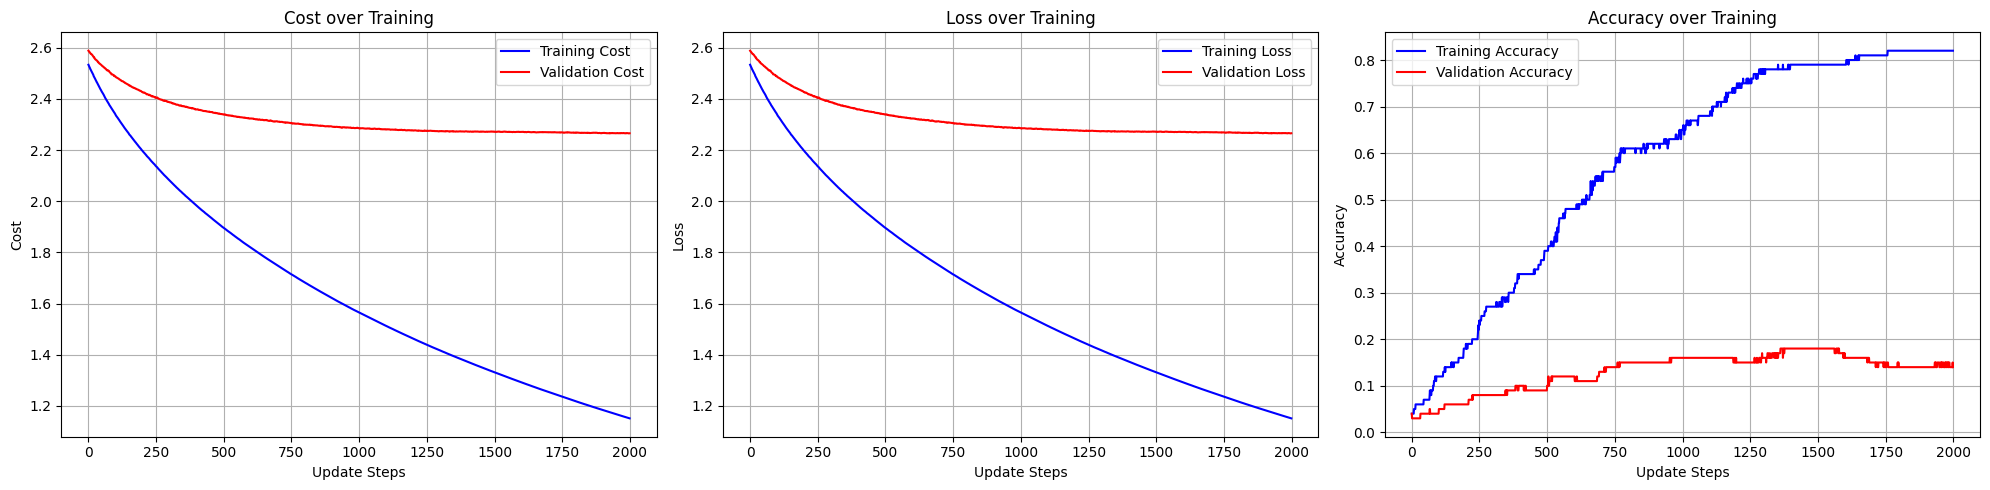

In [47]:
# Example hyperparameters
n_samples = 100
n_batch = 1
lam = 0
nbr_epochs = 200
eta = 0.00001

d = 3072
m = 50
K = 10


# Train the model
overfitted_net, history = MiniBatchGD(X_train[:,0:n_samples], Y_train[:,0:n_samples],X_val[:,0:n_samples], Y_val[:,0:n_samples], {'n_batch':n_batch, 'eta':eta, 'n_epochs':nbr_epochs}, init_net, lam = 0)
# Plot results
plot_training_curves(history, image_name='overfitted_cost_loss_acc_1.png')

In [52]:
def visualize_W_matrix(trained_net, class_names, save_path="../results/images/W_matrix.png"):
    """
    Visualizes the learnt W matrix from the first layer as class template images.

    Parameters:
        trained_net : dict
            Dictionary containing the trained network parameters.
        class_names : list
            List of class names corresponding to the CIFAR-10 dataset.
        save_path : str
            Path to save the visualized W matrix image.
    """
    plt.figure(figsize=(20, 4))  # Increase the figure size
    plt.suptitle("The learnt W matrix visualized as class template images.", fontsize=16, fontweight='bold')

    # Extract the first layer weights
    W = trained_net['W'][0]  # Shape: (m, d)
    W = W.T  # Transpose to shape (d, m)

    # Reshape the weights for visualization
    W_images = W.reshape((32, 32, 3, -1), order='F')  # Shape: (32, 32, 3, m)
    W_images = np.transpose(W_images, (1, 0, 2, 3))  # Shape: (32, 32, 3, m)

    for i in range(10):  # Visualize the first 10 classes
        w_im = W_images[:, :, :, i]
        w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))  # Normalize for visualization
        plt.subplot(1, 10, i + 1)
        plt.imshow(w_im_norm, interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[i], fontsize=15, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to fit the title
    plt.savefig(save_path)
    print(f"Visualization saved to {save_path}")


Visualization saved to ../results/images/W_matrix.png


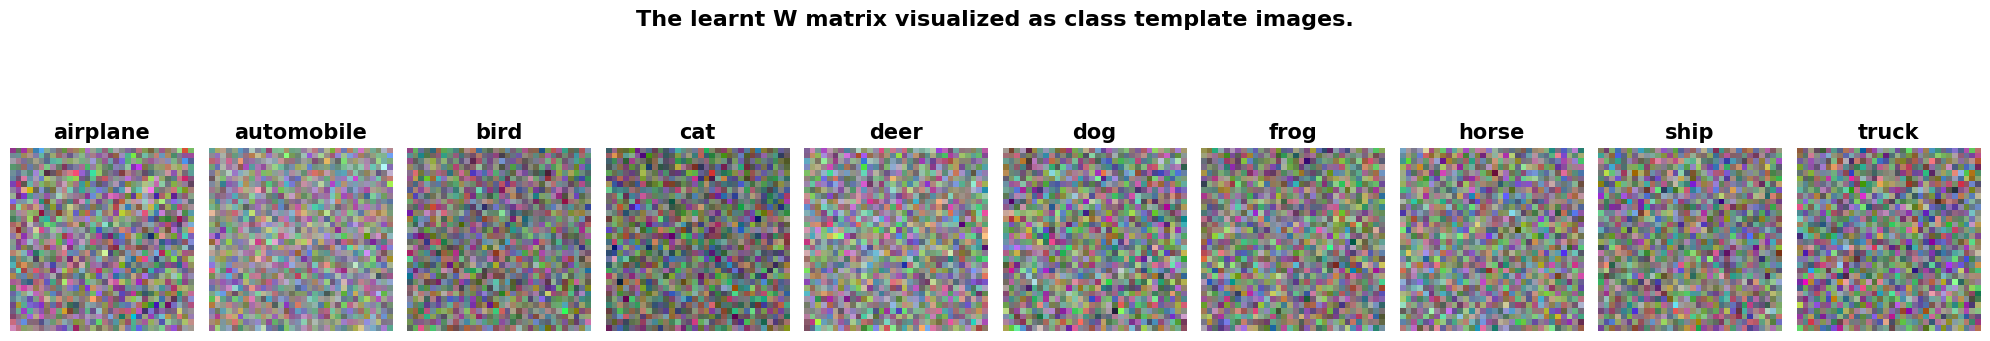

In [53]:

# Run the function
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

visualize_W_matrix(overfitted_net, class_names)


## Exercise 3 - Train network with cyclic learning rate

In [54]:
def get_cyclical_learning_rate(update_step, eta_min, eta_max, step_size):
    """
    Computes the learning rate for the current update step using cyclical learning rates.
    
    Args:
      update_step: Current update step (integer)
      eta_min: Minimum learning rate
      eta_max: Maximum learning rate
      step_size: Step size (half cycle length)
    
    Returns:
      eta: Current learning rate
    """
    # Find which cycle we're in
    cycle = update_step // (2 * step_size)
    
    # Calculate local step within the cycle
    local_step = update_step - cycle * 2 * step_size
    
    # First half of the cycle: increase eta linearly
    if local_step < step_size:
        # Equation (14) from the assignment
        eta = eta_min + (local_step / step_size) * (eta_max - eta_min)
    # Second half of the cycle: decrease eta linearly 
    else:
        # Equation (15) from the assignment
        eta = eta_max - ((local_step - step_size) / step_size) * (eta_max - eta_min)
    
    return eta


def MiniBatchGD_CLR(X_train, Y_train, X_val, Y_val, CLRparams, init_net, lam, logging_freq=10, verbose=True):
    """
    Performs Mini-Batch Gradient Descent with Cyclical Learning Rates and tracks training progress.
    
    Args:
      X_train : (d, N_train) Training input data.
      Y_train : (K, N_train) One-hot encoded training labels.
      X_val   : (d, N_val) Validation input data.
      Y_val   : (K, N_val) One-hot encoded validation labels.
      CLRparams: Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta_min": Minimum learning rate
                 - "eta_max": Maximum learning rate
                 - "n_s": Step size (half cycle length)
                 - "n_cycles": Number of cycles to run
      init_net: Dictionary with initial parameters:
                 - 'W': [W1, W2] weight matrices
                 - 'b': [b1, b2] bias vectors
      lam     : Regularization coefficient.
      logging_freq: How often to compute and log metrics (every 'logging_freq' updates)
      verbose : Whether to print progress messages
    
    Returns:
      trained_net: Dictionary with learned parameters.
      history: Dictionary containing training metrics.
    """
    trained_net = copy.deepcopy(init_net)  # Avoid modifying original network

    # Extract hyperparameters
    n_batch = CLRparams["n_batch"]
    eta_min = CLRparams["eta_min"]
    eta_max = CLRparams["eta_max"]
    step_size = CLRparams["n_s"]
    n_cycles = CLRparams["n_cycles"]
    
    # Calculate total number of update steps to run
    n_updates_per_cycle = 2 * step_size
    total_updates = n_cycles * n_updates_per_cycle
    
    N_train = X_train.shape[1]  # Number of training samples
    N_val = X_val.shape[1]  # Number of validation samples
    
    rng = np.random.default_rng(seed=42)  # Reproducible shuffling
    
    # Tracking loss, cost, and accuracy
    history = {
        "cost_train": [], "cost_val": [],
        "loss_train": [], "loss_val": [],
        "acc_train": [], "acc_val": [],
        "update_steps": [],
        "learning_rates": []
    }

    update_step = 0  # Track updates
    
    # Continue training until we've completed the specified number of updates
    while update_step < total_updates:
        # Shuffle training data for this epoch
        shuffled_indices = rng.permutation(N_train)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        # Process mini-batches for this epoch
        for j in range(N_train // n_batch):
            # Skip once we've done enough updates
            if update_step >= total_updates:
                break
                
            # Get current learning rate based on update step
            eta = get_cyclical_learning_rate(update_step, eta_min, eta_max, step_size)
            
            # Extract mini-batch
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]
            Ybatch = Y_shuffled[:, j_start:j_end]

            # Forward pass
            fp_data = ApplyNetwork(Xbatch, trained_net)
            
            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, fp_data, trained_net, lam)

            # Update parameters with current learning rate
            for i in range(2):  # Two layers
                trained_net["W"][i] -= eta * grads["W"][i]
                trained_net["b"][i] -= eta * grads["b"][i]

            # Record metrics periodically
            if update_step % logging_freq == 0:
                # Compute metrics for training set
                fp_data_train = ApplyNetwork(X_train, trained_net)
                P_train = fp_data_train['p']
                y_train_indices = np.argmax(Y_train, axis=0)
                loss_train = ComputeLoss(P_train, y_train_indices, trained_net["W"], 0)  # Loss without regularization
                cost_train = ComputeLoss(P_train, y_train_indices, trained_net["W"], lam)  # Cost with regularization
                acc_train = np.mean(np.argmax(P_train, axis=0) == y_train_indices)

                # Compute metrics for validation set
                fp_data_val = ApplyNetwork(X_val, trained_net)
                P_val = fp_data_val['p']
                y_val_indices = np.argmax(Y_val, axis=0)
                loss_val = ComputeLoss(P_val, y_val_indices, trained_net["W"], 0)  # Loss without regularization
                cost_val = ComputeLoss(P_val, y_val_indices, trained_net["W"], lam)  # Cost with regularization
                acc_val = np.mean(np.argmax(P_val, axis=0) == y_val_indices)

                # Store in history
                history["cost_train"].append(cost_train)
                history["cost_val"].append(cost_val)
                history["loss_train"].append(loss_train)
                history["loss_val"].append(loss_val)
                history["acc_train"].append(acc_train)
                history["acc_val"].append(acc_val)
                history["update_steps"].append(update_step)
                history["learning_rates"].append(eta)
                
                if verbose and update_step % (logging_freq * 10) == 0:
                    cycle_progress = update_step / n_updates_per_cycle
                    total_progress = update_step / total_updates
                    print(f"Update step {update_step}/{total_updates} - Cycle {int(cycle_progress)}.{int(10*(cycle_progress-int(cycle_progress)))} - "
                          f"Eta: {eta:.6f} - Cost: {cost_train:.4f} - Accuracy: {acc_train:.4f}")

            update_step += 1

    return trained_net, history


def ComputeLoss(P, y, W, lam):
    """
    Computes the cost function value (cross-entropy loss + regularization).
    
    Args:
      P: Probability outputs from the network (K, N)
      y: Ground truth labels as indices (N,)
      W: List of weight matrices [W1, W2]
      lam: Regularization coefficient
    
    Returns:
      loss: Cross-entropy loss value
      cost: Cross-entropy loss + regularization
    """
    # Number of samples
    N = P.shape[1]
    
    # Cross-entropy loss: -1/N * sum(log(p_y))
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    ce_loss = -np.mean(np.log(P[y, np.arange(N)] + epsilon))
    
    # Regularization term: lambda * sum(W_ij^2)
    reg_term = 0
    if lam > 0:
        for w in W:
            reg_term += lam * np.sum(w**2)
            
    # Total cost
    cost = ce_loss + reg_term
    
    return cost


def plot_training_curves_clr(history, image_name='clr_training_curves.png'):
    """
    Plots training and validation cost, loss, and accuracy over update steps
    with cyclical learning rates.
    
    Args:
      history: Dictionary containing training metrics
      image_name: Filename for saving the plot
    """
    save_dir = "."  # Change to your desired directory
    path = os.path.join(save_dir, image_name)
    
    # Create a figure with 4 subplots (including learning rate plot)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    steps = history["update_steps"]
    
    # Cost plot
    axes[0, 0].plot(steps, history["cost_train"], label="Training", color="blue")
    axes[0, 0].plot(steps, history["cost_val"], label="Validation", color="red")
    axes[0, 0].set_title("Cost plot")
    axes[0, 0].set_xlabel("Update step")
    axes[0, 0].set_ylabel("Cost")
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss plot
    axes[0, 1].plot(steps, history["loss_train"], label="Training", color="blue")
    axes[0, 1].plot(steps, history["loss_val"], label="Validation", color="red")
    axes[0, 1].set_title("Loss plot")
    axes[0, 1].set_xlabel("Update step")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Accuracy plot
    axes[1, 0].plot(steps, history["acc_train"], label="Training", color="blue")
    axes[1, 0].plot(steps, history["acc_val"], label="Validation", color="red")
    axes[1, 0].set_title("Accuracy plot")
    axes[1, 0].set_xlabel("Update step")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rate plot
    axes[1, 1].plot(steps, history["learning_rates"], color="green")
    axes[1, 1].set_title("Learning Rate")
    axes[1, 1].set_xlabel("Update step")
    axes[1, 1].set_ylabel("Learning Rate")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

Loading and preprocessing datasets...
Initializing network parameters...
Training network with cyclical learning rates for 1 cycle(s)...
Parameters: eta_min=1e-05, eta_max=0.1, step_size=500
Update step 0/1000 - Cycle 0.0 - Eta: 0.000010 - Cost: 3.0712 - Accuracy: 0.0975
Update step 100/1000 - Cycle 0.1 - Eta: 0.020008 - Cost: 2.4149 - Accuracy: 0.3651
Update step 200/1000 - Cycle 0.2 - Eta: 0.040006 - Cost: 2.1689 - Accuracy: 0.4268
Update step 300/1000 - Cycle 0.3 - Eta: 0.060004 - Cost: 2.0119 - Accuracy: 0.4574
Update step 400/1000 - Cycle 0.4 - Eta: 0.080002 - Cost: 1.8860 - Accuracy: 0.4707
Update step 500/1000 - Cycle 0.5 - Eta: 0.100000 - Cost: 1.8577 - Accuracy: 0.4483
Update step 600/1000 - Cycle 0.6 - Eta: 0.080002 - Cost: 1.6825 - Accuracy: 0.5069
Update step 700/1000 - Cycle 0.7 - Eta: 0.060004 - Cost: 1.5633 - Accuracy: 0.5543
Update step 800/1000 - Cycle 0.8 - Eta: 0.040006 - Cost: 1.5097 - Accuracy: 0.5750
Update step 900/1000 - Cycle 0.9 - Eta: 0.020008 - Cost: 1.4647 

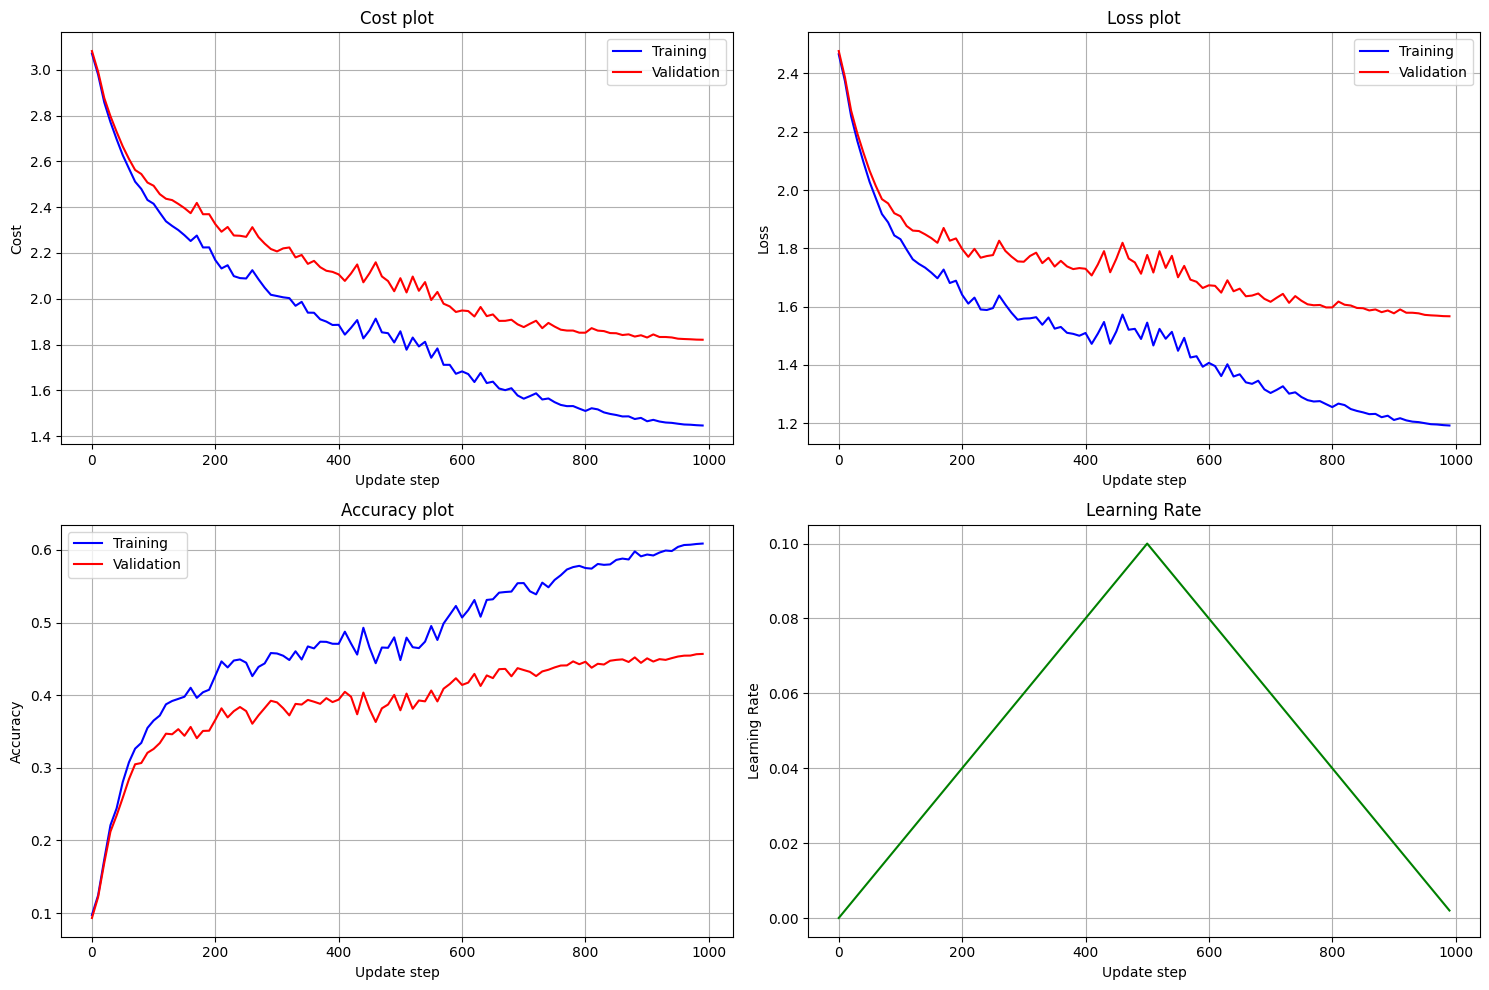

Evaluating on the test set...
Test accuracy: 0.4575

Running Exercise 4: Training with 3 cycles and n_s=800...
Update step 0/4800 - Cycle 0.0 - Eta: 0.000010 - Cost: 3.0712 - Accuracy: 0.0975
Update step 300/4800 - Cycle 0.1 - Eta: 0.037506 - Cost: 2.0858 - Accuracy: 0.4550
Update step 600/4800 - Cycle 0.3 - Eta: 0.075002 - Cost: 1.7906 - Accuracy: 0.4868
Update step 900/4800 - Cycle 0.5 - Eta: 0.087501 - Cost: 1.6075 - Accuracy: 0.5225
Update step 1200/4800 - Cycle 0.7 - Eta: 0.050005 - Cost: 1.4468 - Accuracy: 0.5992
Update step 1500/4800 - Cycle 0.9 - Eta: 0.012509 - Cost: 1.3587 - Accuracy: 0.6433
Update step 1800/4800 - Cycle 1.1 - Eta: 0.025008 - Cost: 1.3594 - Accuracy: 0.6434
Update step 2100/4800 - Cycle 1.3 - Eta: 0.062504 - Cost: 1.4562 - Accuracy: 0.6050
Update step 2400/4800 - Cycle 1.5 - Eta: 0.100000 - Cost: 1.5612 - Accuracy: 0.5442
Update step 2700/4800 - Cycle 1.6 - Eta: 0.062504 - Cost: 1.4304 - Accuracy: 0.6051
Update step 3000/4800 - Cycle 1.8 - Eta: 0.025008 - Cos

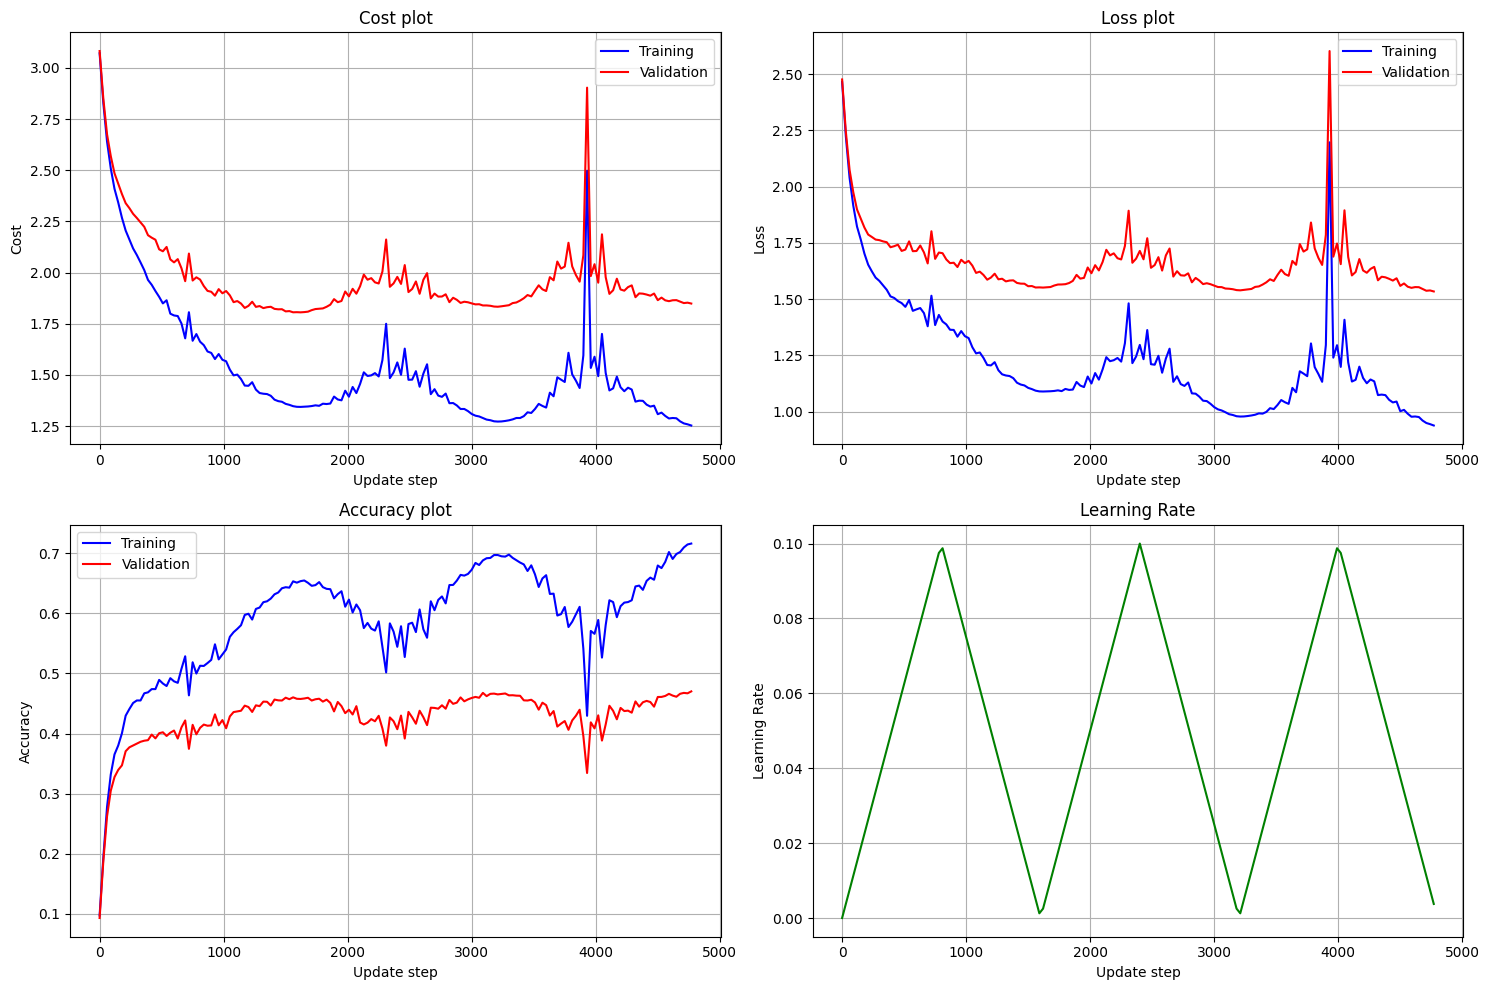

Test accuracy after 3 cycles: 0.4706


In [55]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and preprocess data as specified in the assignment
# Load 1 batch for training and 1 for validation for this exercise
print("Loading and preprocessing datasets...")
X_train_raw, Y_train, y_train = LoadBatch(1)  # data_batch_1 for training
X_val_raw, Y_val, y_val = LoadBatch(2)        # data_batch_2 for validation
X_test_raw, Y_test, y_test = LoadBatch("test_batch")  # test_batch for testing

# Preprocess the data
X_train, X_val, X_test = preprocessData(X_train_raw, X_val_raw, X_test_raw)

# 2. Initialize network parameters
print("Initializing network parameters...")
d = X_train.shape[0]  # Input dimension (3072 for CIFAR-10)
m = 50               # Hidden layer size
K = 10               # Number of classes
init_net = initialize_parameters(d, m, K, seed=42)

# 3. Set up cyclical learning rate parameters as specified in the assignment
# According to the assignment, initially use:
#   - eta_min = 1e-5
#   - eta_max = 1e-1
#   - n_s = 500 (step size)
#   - batch size = 100
lam = 0.01  # Default regularization parameter from the assignment

clr_params = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 500,
    "n_cycles": 1  # For one cycle of training as mentioned in the assignment
}

# 4. Train the network with cyclical learning rates
print(f"Training network with cyclical learning rates for {clr_params['n_cycles']} cycle(s)...")
print(f"Parameters: eta_min={clr_params['eta_min']}, eta_max={clr_params['eta_max']}, step_size={clr_params['n_s']}")

# Train for one cycle (as per Exercise 3)
trained_net, history = MiniBatchGD_CLR(
    X_train, Y_train, X_val, Y_val, 
    clr_params, init_net, lam,
    logging_freq=10, verbose=True
)

# 5. Plot the results
print("Plotting training curves...")
plot_training_curves_clr(history, image_name='cyclical_learning_one_cycle.png')

# 6. Evaluate on the test set
print("Evaluating on the test set...")
fp_data_test = ApplyNetwork(X_test, trained_net)
P_test = fp_data_test['p']
acc_test = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
print(f"Test accuracy: {acc_test:.4f}")

# Now let's run for 3 cycles with n_s=800 as specified in Exercise 4
print("\nRunning Exercise 4: Training with 3 cycles and n_s=800...")
clr_params_ex4 = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 800,
    "n_cycles": 3
}

trained_net_ex4, history_ex4 = MiniBatchGD_CLR(
    X_train, Y_train, X_val, Y_val,
    clr_params_ex4, init_net, lam,
    logging_freq=30, verbose=True
)

# Plot the results for Exercise 4
plot_training_curves_clr(history_ex4, image_name='cyclical_learning_three_cycles.png')

# Evaluate on the test set
fp_data_test = ApplyNetwork(X_test, trained_net_ex4)
P_test = fp_data_test['p']
acc_test = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
print(f"Test accuracy after 3 cycles: {acc_test:.4f}")